In [69]:
#KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc, 
    precision_recall_curve, average_precision_score
) 

In [70]:
#VERİYİ KODA AKTARMA
file_name = "CDC_Wastewater_Data_for_Influenza_A.csv"
df = pd.read_csv(file_name, low_memory=False)
print('Veri temizliliğine ve özellik mühendisliğine başlanılıyor')

Veri temizliliğine ve özellik mühendisliğine başlanılıyor


In [71]:
#VERİ TEMİZLEME VE ÖZELLİK MÜHENDİSLİĞİ
#Zaman Özellikleri (Time-Based Features)
df['sample_collect_date'] = pd.to_datetime(df['sample_collect_date'], errors='coerce')
df['collection_month'] = df['sample_collect_date'].dt.month
df['collection_week'] = df['sample_collect_date'].dt.isocalendar().week.astype(int)
df['collection_dayofweek'] = df['sample_collect_date'].dt.dayofweek
df['is_weekend'] = df['collection_dayofweek'].isin([5, 6]).astype(int)

In [72]:
#Eksik Veri Yönetimi (Imputation)
df['flow_rate_missing'] = df['flow_rate'].isnull().astype(int)
flow_median = df['flow_rate'].median()
df['flow_rate'] = df['flow_rate'].fillna(flow_median)

In [73]:
df['pcr_target_flowpop_lin'] = df['pcr_target_flowpop_lin'].fillna(df['pcr_target_flowpop_lin'].median())
df['flowpop_lin_missing'] = df['pcr_target_flowpop_lin'].isnull().astype(int)

In [74]:
#Dönüşüm (Transformation)
df['log_population_served'] = np.log1p(df['population_served'])
df['log_flow_rate'] = np.log1p(df['flow_rate'])

In [75]:
df['log_flow_per_capita'] = df['log_flow_rate'] - df['log_population_served']

#Hedef Değişken (Target Variable) Oluşturma
df['influenza_a_detected'] = (df['pcr_target_avg_conc'] > 0).astype(int)
df['log_pcr_target_conc'] = np.log1p(df['pcr_target_avg_conc'])

In [76]:
#Gruplama (Binning) ve Akıllı FE (Mevsim)
bins = [0, 20000, 50000, 200000, np.inf]
labels = ['Small', 'Medium', 'Large', 'Very Large']
df['population_group'] = pd.cut(df['population_served'], bins=bins, labels=labels, right=False)

In [77]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else: # 9, 10, 11
        return 'Fall'

df['season'] = df['collection_month'].dropna().apply(get_season)

In [78]:
#Final Temizlik (Cleaning)
columns_to_drop = [
    'inhibition_adjust', 'sample_id', 'date_updated', 'rec_eff_target_name', 
    'rec_eff_spike_matrix', 'rec_eff_spike_conc', 'hum_frac_mic_unit', 
    'pcr_target_mic_lin', 'hum_frac_mic_conc', 'hum_frac_target_mic',
    'ntc_amplify', 
    'pcr_target' 
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [79]:
df['pasteurized'] = df['pasteurized'].fillna(df['pasteurized'].mode()[0])
df['counties_served'] = df['counties_served'].fillna(df['counties_served'].mode()[0])
df['lod_sewage'] = df['lod_sewage'].fillna(df['lod_sewage'].median())
df['pcr_gene_target_agg'] = df['pcr_gene_target_agg'].fillna(df['pcr_gene_target_agg'].mode()[0])
df['rec_eff_percent'] = np.clip(df['rec_eff_percent'], a_min=None, a_max=100) # Capping

df.drop_duplicates(inplace=True)

In [80]:
#Kodlama (Encoding)
pop_kategorileri = pd.CategoricalDtype(
    categories=['Small', 'Medium', 'Large', 'Very Large'], 
    ordered=True
)
df['population_group'] = df['population_group'].astype(pop_kategorileri)
df['population_group_encoded'] = df['population_group'].cat.codes
print('Veri temizliliği ve özellik mühendisliği bitti')
#VERİ TEMİZLİĞİ VE ÖZELLİK MÜHENDİSLİĞİ BİTTİ

Veri temizliliği ve özellik mühendisliği bitti


In [81]:
#KEŞİFSEL ANALİZ (EDA) - TÜM GRAFİKLER
print("Keşifsel Analizin (EDA) Ana Grafik Çıktıları")
#Haftalık Mevsimsel Eğilim (Zaman Serisi)
weekly_avg = df.set_index('sample_collect_date')['pcr_target_avg_conc'].resample('W').mean().reset_index()

Keşifsel Analizin (EDA) Ana Grafik Çıktıları


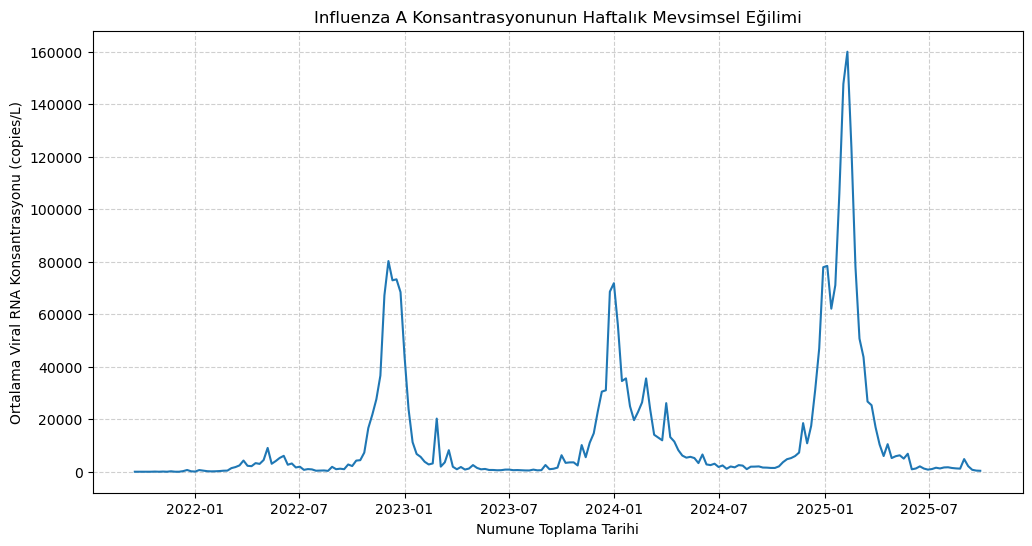

In [82]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_avg, x='sample_collect_date', y='pcr_target_avg_conc')
plt.title('Influenza A Konsantrasyonunun Haftalık Mevsimsel Eğilimi')
plt.xlabel('Numune Toplama Tarihi')
plt.ylabel('Ortalama Viral RNA Konsantrasyonu (copies/L)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

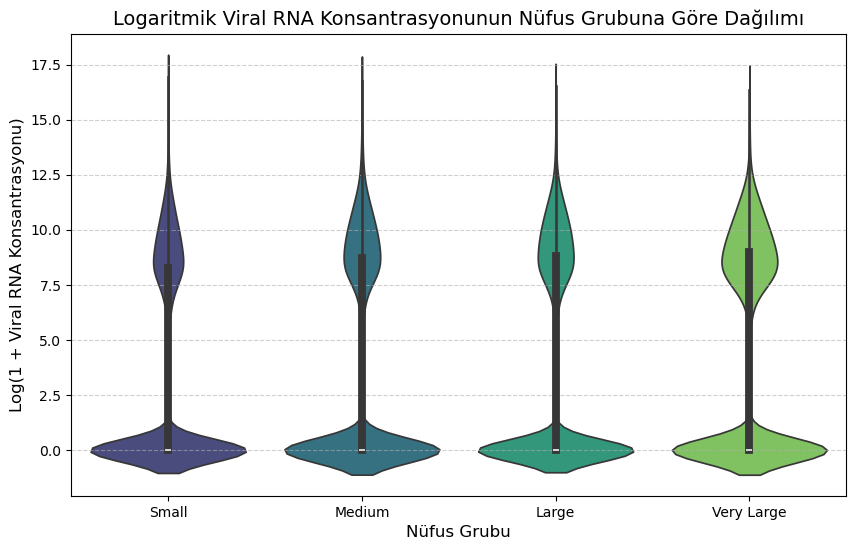

In [83]:
#Nüfus Grubuna Göre Dağılım (Keman Grafiği)
plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df['population_group'].astype(str), y='log_pcr_target_conc', data=df, 
    order=['Small', 'Medium', 'Large', 'Very Large'], palette='viridis',
    hue=df['population_group'].astype(str), legend=False 
)
plt.title('Logaritmik Viral RNA Konsantrasyonunun Nüfus Grubuna Göre Dağılımı', fontsize=14)
plt.xlabel('Nüfus Grubu', fontsize=12)
plt.ylabel('Log(1 + Viral RNA Konsantrasyonu)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show() 

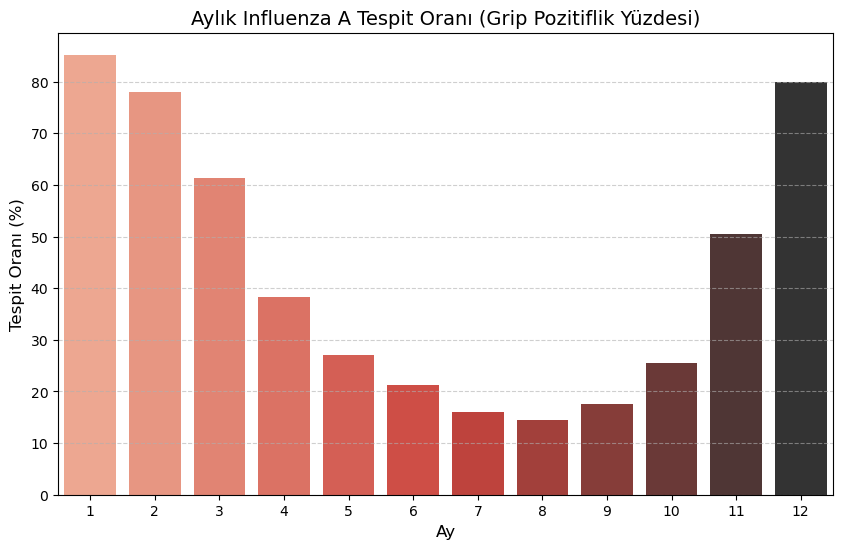

In [84]:
#Aylık Pozitiflik Oranı (Çubuk Grafik)
monthly_total = df.groupby('collection_month').size().reset_index(name='total_samples')
monthly_detected = df[df['influenza_a_detected'] == 1].groupby('collection_month').size().reset_index(name='detected_samples')
monthly_detection_rate = pd.merge(monthly_total, monthly_detected, on='collection_month', how='left')
monthly_detection_rate['detected_samples'] = monthly_detection_rate['detected_samples'].fillna(0)
monthly_detection_rate['detection_rate'] = (monthly_detection_rate['detected_samples'] / monthly_total['total_samples']) * 100
plt.figure(figsize=(10, 6))
sns.barplot(
    x='collection_month', y='detection_rate', data=monthly_detection_rate, 
    palette='Reds_d', hue='collection_month', legend=False 
)
plt.title('Aylık Influenza A Tespit Oranı (Grip Pozitiflik Yüzdesi)', fontsize=14)
plt.xlabel('Ay', fontsize=12)
plt.ylabel('Tespit Oranı (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show() 

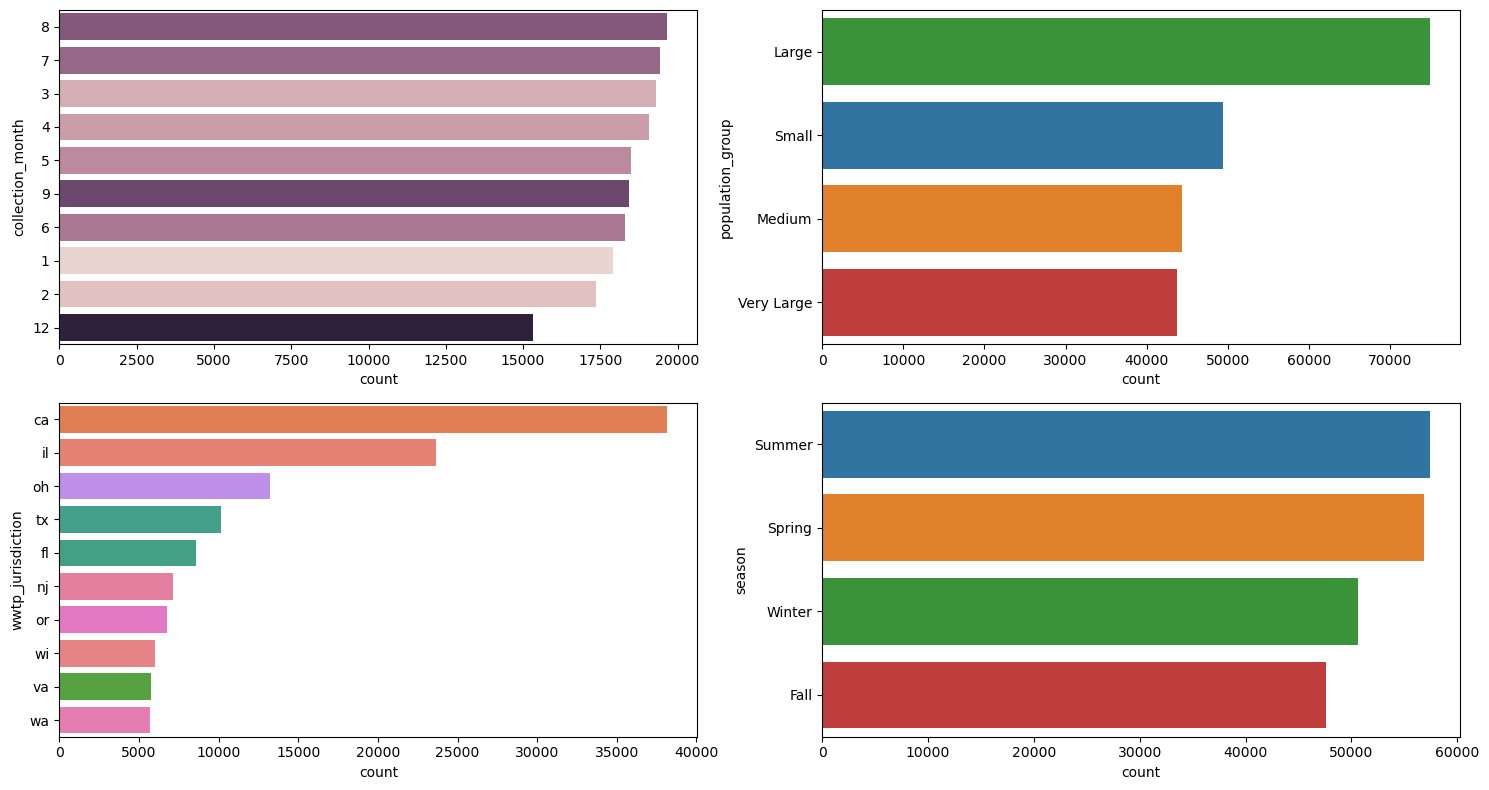

In [85]:
#Kategorik Dökümler (Sıklık Grafiği)
categorical_cols_for_plot = ['collection_month', 'population_group', 'wwtp_jurisdiction', 'season'] 
plt.figure(figsize=(15, 8)) 

for i, col in enumerate(categorical_cols_for_plot):
    plt.subplot(2, 2, i + 1) 
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:10], hue=col, legend=False)
plt.tight_layout()
plt.show()

In [86]:
#KAYDETME
output_file_name = "temizlenmis_veri_seti_FINAL_koddan_olustu.csv"
df.to_csv(output_file_name, index=False)
print(f"\nTemizlenmiş ve (population_group_encoded) içeren veri seti başarıyla kaydedildi: {output_file_name}")


Temizlenmiş ve (population_group_encoded) içeren veri seti başarıyla kaydedildi: temizlenmis_veri_seti_FINAL_koddan_olustu.csv


In [87]:
print("MODEL HAZIRLAMA VE KARŞILAŞTIRMA")
#ÖZELLİK VE HEDEF BELİRLEME (Feature & Target)
features = [
    'collection_month', 'collection_week', 'collection_dayofweek', 
    'log_population_served', 'log_flow_rate', 'rec_eff_percent', 
    'flow_rate_missing', 'flowpop_lin_missing', 
    'population_group_encoded', 
    'wwtp_jurisdiction', 
    'is_weekend',
    'log_flow_per_capita',
    'season'
]

MODEL HAZIRLAMA VE KARŞILAŞTIRMA


In [88]:
X = df[features]
y = df['influenza_a_detected'] # Hedef Sınıflandırma

#ENCODING (KODLAMA)
X = pd.get_dummies(X, columns=['wwtp_jurisdiction', 'season'], drop_first=True)

print(f"Modelin Kullanacağı Toplam Orjinal Özellik Sayısı (Encoding sonrası): {X.shape[1]}")

Modelin Kullanacağı Toplam Orjinal Özellik Sayısı (Encoding sonrası): 64


In [89]:
#VERİYİ BÖLME (Train/Test Split)
X.fillna(0, inplace=True) # NaN'ları doldur
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [90]:
#VERİ ÖLÇEKLEME (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
#BOYUT İNDİRGEME (Dimension Reduction)
print("\nPCA uygulanıyor...")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"PCA sonrası özellik sayısı {X_train_scaled.shape[1]}'dan {pca.n_components_}'a düşürüldü.")


PCA uygulanıyor...
PCA sonrası özellik sayısı 64'dan 53'a düşürüldü.


In [92]:
#MODELLERİN EĞİTİMİ
print("\n4 farklı senaryo için modeller eğitiliyor...")

# Model 1: SGDClassifier (PCA'SIZ)
model_sgd_nosca = SGDClassifier(random_state=42, class_weight='balanced', loss="log_loss", n_jobs=-1)
model_sgd_nosca.fit(X_train_scaled, y_train) # PCA'sız veri ile eğit
print("SGDClassifier (PCA'sız) eğitildi.")

# Model 2: GaussianNB (PCA'SIZ)
model_nb_nosca = GaussianNB()
model_nb_nosca.fit(X_train_scaled, y_train) # PCA'sız veri ile eğit
print("GaussianNB (PCA'sız) eğitildi.")

# Model 3: SGDClassifier (PCA'LI)
model_sgd_pca = SGDClassifier(random_state=42, class_weight='balanced', loss="log_loss", n_jobs=-1)
model_sgd_pca.fit(X_train_pca, y_train) # PCA'lı veri ile eğit
print("SGDClassifier (PCA'lı) eğitildi.")

# Model 4: GaussianNB (PCA'LI)
model_nb_pca = GaussianNB()
model_nb_pca.fit(X_train_pca, y_train) # PCA'lı veri ile eğit
print("GaussianNB (PCA'lı) eğitildi.")


4 farklı senaryo için modeller eğitiliyor...
SGDClassifier (PCA'sız) eğitildi.
GaussianNB (PCA'sız) eğitildi.
SGDClassifier (PCA'lı) eğitildi.
GaussianNB (PCA'lı) eğitildi.


In [93]:
#METİN BAZLI DEĞERLENDİRME
#SGD (PCA'sız) Sonuçları
y_pred_sgd_nosca = model_sgd_nosca.predict(X_test_scaled)
accuracy_sgd_nosca = accuracy_score(y_test, y_pred_sgd_nosca)
report_sgd_nosca = classification_report(y_test, y_pred_sgd_nosca, target_names=['Grip Yok (0)', 'Grip Var (1)'])
conf_matrix_sgd_nosca = confusion_matrix(y_test, y_pred_sgd_nosca)
print("\n--- 1. SGDClassifier Raporu (PCA'sız) ---")
print(f"Model Doğruluğu (Accuracy): {accuracy_sgd_nosca:.4f}")
print(report_sgd_nosca)

# Naive Bayes (PCA'sız) Sonuçları
y_pred_nb_nosca = model_nb_nosca.predict(X_test_scaled)
accuracy_nb_nosca = accuracy_score(y_test, y_pred_nb_nosca)
report_nb_nosca = classification_report(y_test, y_pred_nb_nosca, target_names=['Grip Yok (0)', 'Grip Var (1)'])
conf_matrix_nb_nosca = confusion_matrix(y_test, y_pred_nb_nosca)
print("\n--- 2. GaussianNB Raporu (PCA'sız) ---")
print(f"Model Doğruluğu (Accuracy): {accuracy_nb_nosca:.4f}")
print(report_nb_nosca)

# SGD (PCA'lı) Sonuçları
y_pred_sgd_pca = model_sgd_pca.predict(X_test_pca)
accuracy_sgd_pca = accuracy_score(y_test, y_pred_sgd_pca)
report_sgd_pca = classification_report(y_test, y_pred_sgd_pca, target_names=['Grip Yok (0)', 'Grip Var (1)'])
conf_matrix_sgd_pca = confusion_matrix(y_test, y_pred_sgd_pca)
print("\n--- 3. SGDClassifier Raporu (PCA'lı) ---")
print(f"Model Doğruluğu (Accuracy): {accuracy_sgd_pca:.4f}")
print(report_sgd_pca)

# Naive Bayes (PCA'lı) Sonuçları
y_pred_nb_pca = model_nb_pca.predict(X_test_pca)
accuracy_nb_pca = accuracy_score(y_test, y_pred_nb_pca)
report_nb_pca = classification_report(y_test, y_pred_nb_pca, target_names=['Grip Yok (0)', 'Grip Var (1)'])
conf_matrix_nb_pca = confusion_matrix(y_test, y_pred_nb_pca)
print("\n--- 4. GaussianNB Raporu (PCA'lı) ---")
print(f"Model Doğruluğu (Accuracy): {accuracy_nb_pca:.4f}")
print(report_nb_pca)


--- 1. SGDClassifier Raporu (PCA'sız) ---
Model Doğruluğu (Accuracy): 0.7395
              precision    recall  f1-score   support

Grip Yok (0)       0.77      0.78      0.78     24632
Grip Var (1)       0.69      0.68      0.69     17849

    accuracy                           0.74     42481
   macro avg       0.73      0.73      0.73     42481
weighted avg       0.74      0.74      0.74     42481


--- 2. GaussianNB Raporu (PCA'sız) ---
Model Doğruluğu (Accuracy): 0.6815
              precision    recall  f1-score   support

Grip Yok (0)       0.76      0.66      0.71     24632
Grip Var (1)       0.60      0.70      0.65     17849

    accuracy                           0.68     42481
   macro avg       0.68      0.68      0.68     42481
weighted avg       0.69      0.68      0.68     42481


--- 3. SGDClassifier Raporu (PCA'lı) ---
Model Doğruluğu (Accuracy): 0.7368
              precision    recall  f1-score   support

Grip Yok (0)       0.76      0.80      0.78     24632
Grip Va

In [94]:
#GÖRSEL KARŞILAŞTIRMA (ROC, PR VE METRİK TABLOSU)
#Olasılık skorlarını alma (4 senaryo için)
y_scores_sgd_nosca = model_sgd_nosca.predict_proba(X_test_scaled)[:, 1]
y_scores_nb_nosca = model_nb_nosca.predict_proba(X_test_scaled)[:, 1]
y_scores_sgd_pca = model_sgd_pca.predict_proba(X_test_pca)[:, 1]
y_scores_nb_pca = model_nb_pca.predict_proba(X_test_pca)[:, 1]

# ROC Eğrilerini Hesapla
fpr_sgd_nosca, tpr_sgd_nosca, _ = roc_curve(y_test, y_scores_sgd_nosca)
roc_auc_sgd_nosca = auc(fpr_sgd_nosca, tpr_sgd_nosca)
fpr_nb_nosca, tpr_nb_nosca, _ = roc_curve(y_test, y_scores_nb_nosca)
roc_auc_nb_nosca = auc(fpr_nb_nosca, tpr_nb_nosca)
fpr_sgd_pca, tpr_sgd_pca, _ = roc_curve(y_test, y_scores_sgd_pca)
roc_auc_sgd_pca = auc(fpr_sgd_pca, tpr_sgd_pca)
fpr_nb_pca, tpr_nb_pca, _ = roc_curve(y_test, y_scores_nb_pca)
roc_auc_nb_pca = auc(fpr_nb_pca, tpr_nb_pca)

# PR Eğrilerini Hesapla
precision_sgd_nosca, recall_sgd_nosca, _ = precision_recall_curve(y_test, y_scores_sgd_nosca)
ap_sgd_nosca = average_precision_score(y_test, y_scores_sgd_nosca)
precision_nb_nosca, recall_nb_nosca, _ = precision_recall_curve(y_test, y_scores_nb_nosca)
ap_nb_nosca = average_precision_score(y_test, y_scores_nb_nosca)
precision_sgd_pca, recall_sgd_pca, _ = precision_recall_curve(y_test, y_scores_sgd_pca)
ap_sgd_pca = average_precision_score(y_test, y_scores_sgd_pca)
precision_nb_pca, recall_nb_pca, _ = precision_recall_curve(y_test, y_scores_nb_pca)
ap_nb_pca = average_precision_score(y_test, y_scores_nb_pca)

#METRİK TABLOSU
#4 senaryonun tamamını içeren özet tablo
metrics_summary = pd.DataFrame({
    'Model': ['SGDClassifier', 'GaussianNB', 'SGDClassifier', 'GaussianNB'],
    'Veri Seti': ['PCA\'sız (Orijinal)', 'PCA\'sız (Orijinal)', 'PCA\'lı', 'PCA\'lı'],
    'Accuracy': [accuracy_sgd_nosca, accuracy_nb_nosca, accuracy_sgd_pca, accuracy_nb_pca],
    'ROC AUC': [roc_auc_sgd_nosca, roc_auc_nb_nosca, roc_auc_sgd_pca, roc_auc_nb_pca],
    'Average Precision (AP)': [ap_sgd_nosca, ap_nb_nosca, ap_sgd_pca, ap_nb_pca]
})
print("\n--- KARŞILAŞTIRMALI METRİK TABLOSU (PCA ÖNCESİ VE SONRASI) ---")
print(metrics_summary.to_string(index=False))


--- KARŞILAŞTIRMALI METRİK TABLOSU (PCA ÖNCESİ VE SONRASI) ---
        Model          Veri Seti  Accuracy  ROC AUC  Average Precision (AP)
SGDClassifier PCA'sız (Orijinal)  0.739460 0.810159                0.760958
   GaussianNB PCA'sız (Orijinal)  0.681481 0.730683                0.652709
SGDClassifier             PCA'lı  0.736776 0.800613                0.749991
   GaussianNB             PCA'lı  0.655211 0.756748                0.707161


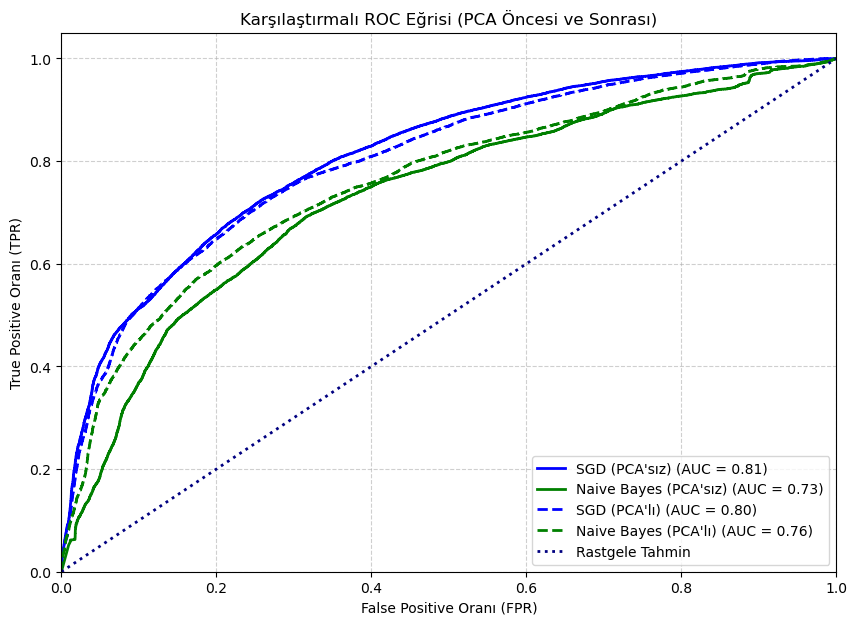

In [95]:
#GÖRSEL KARŞILAŞTIRMALAR
# 1. Karşılaştırmalı ROC Eğrisi Grafiği (4 senaryo)
plt.figure(figsize=(10, 7))
plt.plot(fpr_sgd_nosca, tpr_sgd_nosca, color='blue', linestyle='-', lw=2, label=f'SGD (PCA\'sız) (AUC = {roc_auc_sgd_nosca:.2f})')
plt.plot(fpr_nb_nosca, tpr_nb_nosca, color='green', linestyle='-', lw=2, label=f'Naive Bayes (PCA\'sız) (AUC = {roc_auc_nb_nosca:.2f})')
plt.plot(fpr_sgd_pca, tpr_sgd_pca, color='blue', linestyle='--', lw=2, label=f'SGD (PCA\'lı) (AUC = {roc_auc_sgd_pca:.2f})')
plt.plot(fpr_nb_pca, tpr_nb_pca, color='green', linestyle='--', lw=2, label=f'Naive Bayes (PCA\'lı) (AUC = {roc_auc_nb_pca:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':', label='Rastgele Tahmin')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı (FPR)')
plt.ylabel('True Positive Oranı (TPR)')
plt.title('Karşılaştırmalı ROC Eğrisi (PCA Öncesi ve Sonrası)')
plt.legend(loc="lower right")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

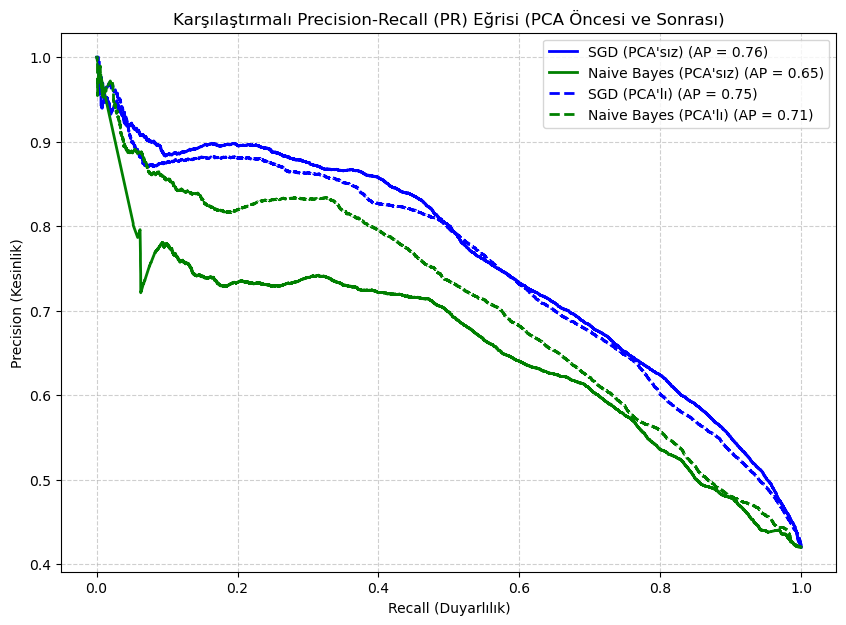

In [96]:
# 2. Karşılaştırmalı PR Eğrisi Grafiği (4 senaryo)
plt.figure(figsize=(10, 7))
plt.plot(recall_sgd_nosca, precision_sgd_nosca, color='blue', linestyle='-', lw=2, label=f'SGD (PCA\'sız) (AP = {ap_sgd_nosca:.2f})')
plt.plot(recall_nb_nosca, precision_nb_nosca, color='green', linestyle='-', lw=2, label=f'Naive Bayes (PCA\'sız) (AP = {ap_nb_nosca:.2f})')
plt.plot(recall_sgd_pca, precision_sgd_pca, color='blue', linestyle='--', lw=2, label=f'SGD (PCA\'lı) (AP = {ap_sgd_pca:.2f})')
plt.plot(recall_nb_pca, precision_nb_pca, color='green', linestyle='--', lw=2, label=f'Naive Bayes (PCA\'lı) (AP = {ap_nb_pca:.2f})')
plt.xlabel('Recall (Duyarlılık)')
plt.ylabel('Precision (Kesinlik)')
plt.title('Karşılaştırmalı Precision-Recall (PR) Eğrisi (PCA Öncesi ve Sonrası)')
plt.legend(loc="best")
plt.grid(linestyle='--', alpha=0.6)
plt.show()


Adım 9: PCA Modellerinin Yorumlanması (Bileşen Önemleri)...


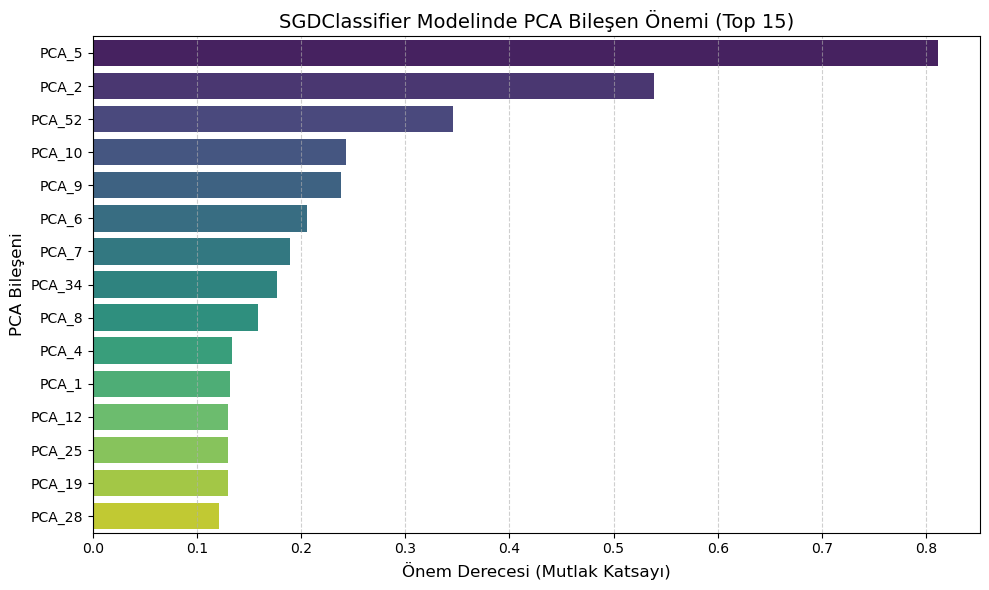

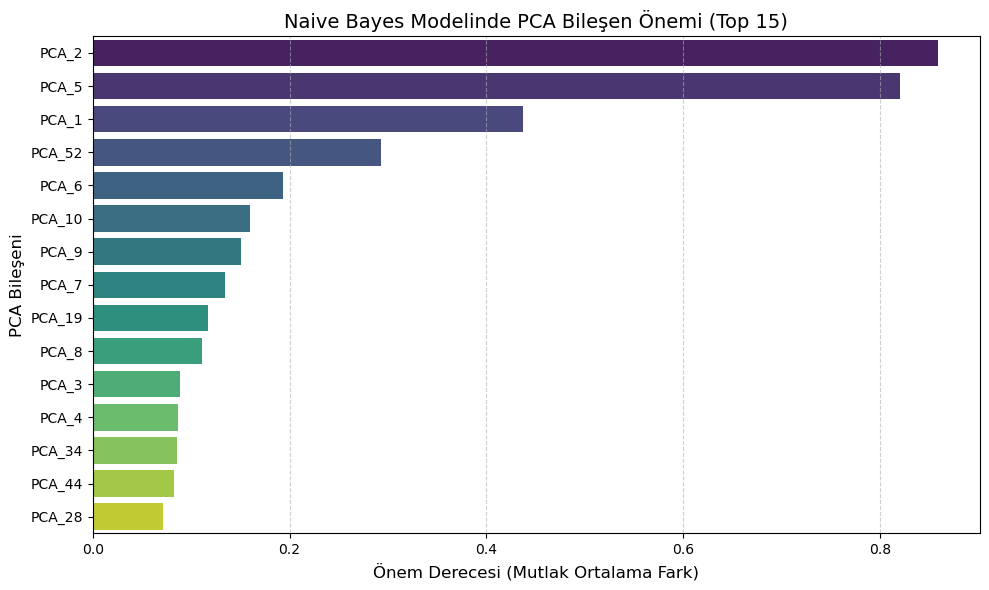

In [97]:
#PCA MODELLERİNİN YORUMLANMASI
print("\nAdım 9: PCA Modellerinin Yorumlanması (Bileşen Önemleri)...")

# PCA bileşenlerinin isimlerini oluştur ('PCA_1', 'PCA_2', ...)
pca_feature_names = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]

# 1. SGDClassifier (PCA ile) Katsayı Grafiği
sgd_pca_coeffs = model_sgd.coef_[0]
pca_importance_sgd = pd.DataFrame({
    'Feature': pca_feature_names,
    'Importance': sgd_pca_coeffs
})
pca_importance_sgd['Abs_Importance'] = np.abs(pca_importance_sgd['Importance'])
pca_importance_sgd = pca_importance_sgd.sort_values(by='Abs_Importance', ascending=False)
top_pca_sgd = pca_importance_sgd.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Abs_Importance', 
    y='Feature', 
    data=top_pca_sgd, 
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('SGDClassifier Modelinde PCA Bileşen Önemi (Top 15)', fontsize=14)
plt.xlabel('Önem Derecesi (Mutlak Katsayı)', fontsize=12)
plt.ylabel('PCA Bileşeni', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() 
plt.show()

# 2. Naive Bayes (PCA ile) Ortalama Fark Grafiği
nb_pca_means_0 = model_nb.theta_[0]
nb_pca_means_1 = model_nb.theta_[1]

pca_importance_nb = pd.DataFrame({
    'Feature': pca_feature_names,
    'Mean_Difference': nb_pca_means_1 - nb_pca_means_0
})
pca_importance_nb['Mean_Abs_Difference'] = np.abs(pca_importance_nb['Mean_Difference'])
pca_importance_nb = pca_importance_nb.sort_values(by='Mean_Abs_Difference', ascending=False)

top_pca_nb = pca_importance_nb.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Mean_Abs_Difference', 
    y='Feature', 
    data=top_pca_nb,
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('Naive Bayes Modelinde PCA Bileşen Önemi (Top 15)', fontsize=14)
plt.xlabel('Önem Derecesi (Mutlak Ortalama Fark)', fontsize=12)
plt.ylabel('PCA Bileşeni', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() 
plt.show()

In [98]:
#PCA BİLEŞENLERİ
print("\n" + "="*50)
print("--- GRAFİKTEKİ 15 PCA BİLEŞENİNİN GERÇEK İÇERİĞİ ---")
print("="*50 + "\n")

original_feature_names = X.columns
df_pca_loadings = pd.DataFrame(
    pca.components_,
    columns=original_feature_names,
    index=pca_feature_names
)

components_in_graph = [
    'PCA_5', 'PCA_2', 'PCA_52', 'PCA_10', 'PCA_9', 'PCA_6', 'PCA_7', 
    'PCA_34', 'PCA_8', 'PCA_4', 'PCA_1', 'PCA_12', 'PCA_25', 
    'PCA_19', 'PCA_28'
]

for component_name in components_in_graph:
    print(f"\n--- {component_name}'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---")
    try:
        component_contents = df_pca_loadings.loc[component_name].abs().sort_values(ascending=False).head(5)
        print(component_contents)
    except KeyError:
        print(f"Hata: {component_name} listede bulunamadı. Lütfen PCA'nızın {pca.n_components_} bileşeni olduğunu kontrol edin.")
        
print("\n" + "="*50)
print("--- DÖKÜM TAMAMLANDI ---")
print("="*50)


--- GRAFİKTEKİ 15 PCA BİLEŞENİNİN GERÇEK İÇERİĞİ ---


--- PCA_5'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---
season_Winter           0.761824
season_Spring           0.559466
season_Summer           0.192947
wwtp_jurisdiction_mi    0.129300
wwtp_jurisdiction_va    0.092548
Name: PCA_5, dtype: float64

--- PCA_2'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---
collection_week     0.603951
collection_month    0.602318
season_Spring       0.376921
season_Summer       0.268210
season_Winter       0.215540
Name: PCA_2, dtype: float64

--- PCA_52'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---
season_Summer           0.438311
wwtp_jurisdiction_or    0.342500
wwtp_jurisdiction_mi    0.327373
wwtp_jurisdiction_la    0.255572
wwtp_jurisdiction_gu    0.226846
Name: PCA_52, dtype: float64

--- PCA_10'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---
wwtp_jurisdiction_il    0.407585
season_Summer           0.277686
wwtp_jurisdiction_ny    0.275369
wwtp_jurisdiction_ca    0.270699
wwtp_jurisdiction_or   

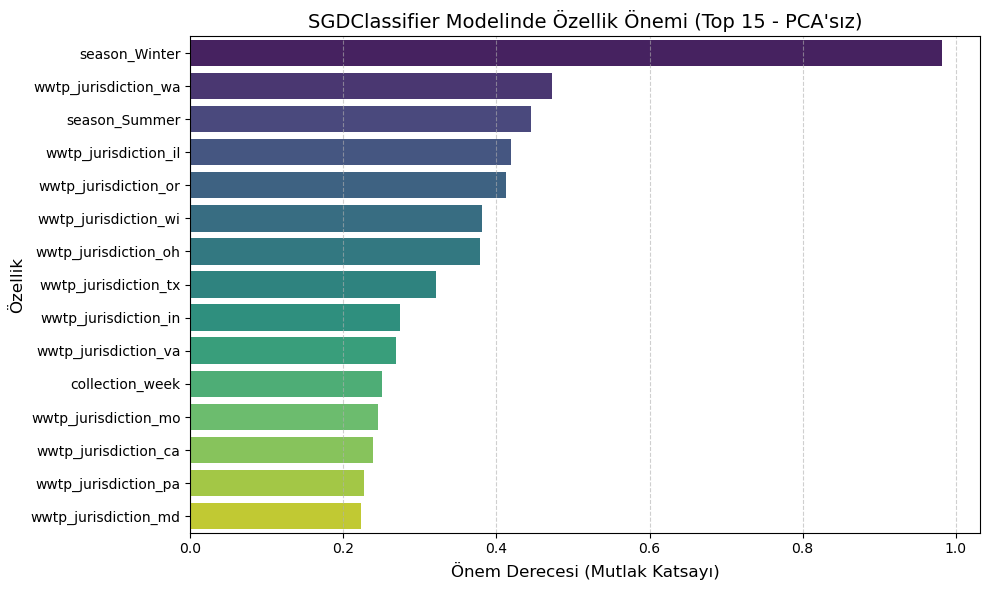


Adım 2: Naive Bayes Model Yorumlaması (Özellik Ortalamaları) çiziliyor...


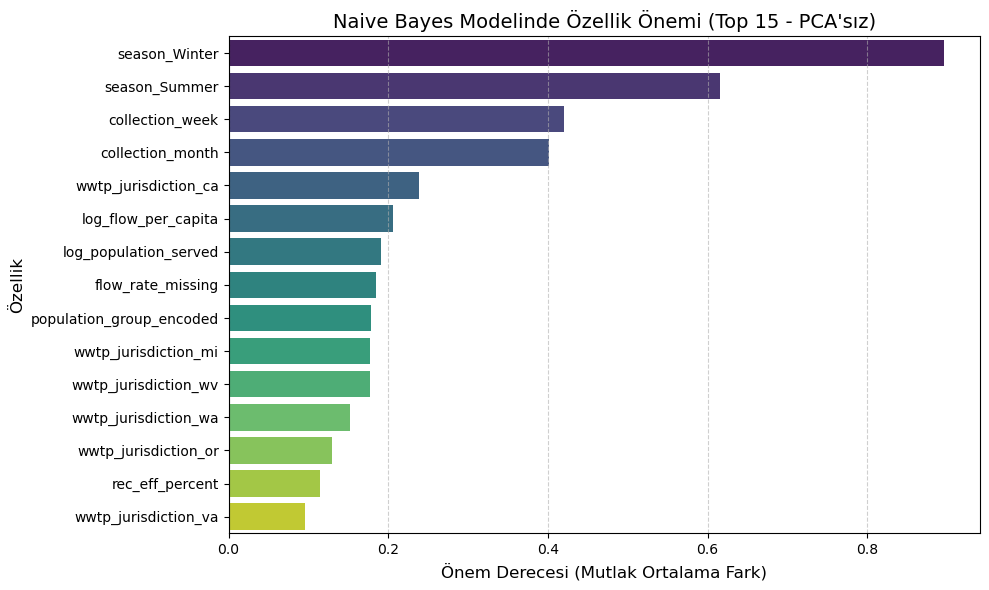

In [99]:
#PCA'SIZ YORUMLAMA
# 1. SGDClassifier (PCA'sız) için Özellik Önemi
model_sgd_interpret = SGDClassifier(random_state=42, class_weight='balanced', loss="log_loss", n_jobs=-1)
model_sgd_interpret.fit(X_train_scaled, y_train) # PCA'sız veri ile eğit

feature_names = X.columns 
sgd_coeffs = model_sgd_interpret.coef_[0]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': sgd_coeffs
})
# Mutlak değere göre sırala (O resimdeki gibi)
importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)
top_features = importance_df.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Abs_Importance', 
    y='Feature', 
    data=top_features, 
    palette='viridis', 
    hue='Feature', 
    legend=False 
)
plt.title('SGDClassifier Modelinde Özellik Önemi (Top 15 - PCA\'sız)', fontsize=14)
plt.xlabel('Önem Derecesi (Mutlak Katsayı)', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() # Etiketlerin sığması için eklendi
plt.show()


# 2. Naive Bayes (PCA'sız) için Özellik Önemi
print("\nAdım 2: Naive Bayes Model Yorumlaması (Özellik Ortalamaları) çiziliyor...")

model_nb_interpret = GaussianNB()
model_nb_interpret.fit(X_train_scaled, y_train) # PCA'sız veri ile eğit

nb_means_class_0 = model_nb_interpret.theta_[0]
nb_means_class_1 = model_nb_interpret.theta_[1]

nb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean_Difference': nb_means_class_1 - nb_means_class_0
})

nb_importance_df['Mean_Abs_Difference'] = np.abs(nb_importance_df['Mean_Difference'])
nb_importance_df = nb_importance_df.sort_values(by='Mean_Abs_Difference', ascending=False)

top_nb_features = nb_importance_df.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Mean_Abs_Difference', 
    y='Feature', 
    data=top_nb_features,
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('Naive Bayes Modelinde Özellik Önemi (Top 15 - PCA\'sız)', fontsize=14)
plt.xlabel('Önem Derecesi (Mutlak Ortalama Fark)', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()